# Making a package for systematics analysis

The idea of this notebook is to take a fully-converged MCMC fit and produce a package of data files suitable for analyzing the unmodelled systematics remaining in the data. It should contain:

* The best-fit parameter names, values, and uncertainties (covariance matrix)
* Names, values, and uncertainties on any parameters obtained by linear fitting
* Names, values, and uncertainties for derived parameters
* The astrometric parameters that went into the calculation
* The settings used in the fitting
* Residuals of the fitting, in the form of a matrix with columns time, residual (phase), uncertainty
* Derivatives of the residuals with respect to all fitted parameters
* Derivatives of an imaginary uniformly sampled data set with respect to all fitted parameters

This package should contain the information needed to do a purely frequentist test of the SEP. We therefore want to be able to produce several variants, as needed:

* `GR` - A plain-GR fit
* `GRplus` - A plain-GR fit but including derivatives with respect to GR-violation parameters
* `heavysimple` - A full GR_violation fit


In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from glob import glob
import os
import time
import cPickle as pickle
import joblib

import scipy.linalg
import scipy.stats

import emcee
import numdifftools

import kepler
import threebody

In [3]:
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.viridis()

In [122]:
name = "dmtesting"

d = os.path.join("derivative-runs", name)
params = pickle.load(open(os.path.join(d,"params.pickle")))
F = threebody.Fitter(**params)
F.best_parameters = pickle.load(
    open(os.path.join(d,"best_parameters.pickle")))
nl_der = {}
for p in F.parameters:
    nl_der[p] = np.load(os.path.join(d,"%s.npy" % p))
params

{'dmx_span': 182.62125,
 'efac': 1,
 'fdn_range': (1, 5),
 'files': 'tuned2_aligned_pulses_1400_nosun2',
 'fit_pm': True,
 'fit_pos': True,
 'fit_px': True,
 'kopeikin': False,
 'linear_dm': True,
 'linear_jumps': True,
 'parfile': '0337_de430.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'toa_mode': 'pipeline',
 'tzrmjd_middle': 'auto',
 'variable_dm': False,
 'variable_ipm': False}

In [123]:
F.best_parameters

{'acosi_i': 1.4895291249240814711,
 'acosi_o': 91.370040344298960579,
 'asini_i': 1.2175248602714382252,
 'asini_o': 74.672605655836887632,
 'dbeta': -0.00027518109097830787457,
 'delta': -1.4754055621614424641e-06,
 'delta_lan': -4.9394851663259015281e-06,
 'dgamma': 1.1191226173457923176e-05,
 'eps1_i': 0.00068862983801145922671,
 'eps1_o': 0.0351858693756688844,
 'eps2_i': -9.1435449845411888786e-05,
 'eps2_o': -0.0034633928347146004358,
 'pb_i': 1.6293921494511599042,
 'pb_o': 327.25666194378581009,
 'q_i': 0.13743287835932569385,
 'tasc_i': 0.40771651431691063058,
 'tasc_o': 313.93493689881574113}

In [124]:
F.goodness_of_fit(F.best_parameters)

39907.054631663787248

In [125]:
orbit = F.compute_orbit(F.best_parameters)
orbit

{'initial_values': array([  1.13356862e+02,   2.15584669e+01,   1.76181032e+01,
          6.75786690e+00,   1.69199455e+00,   1.38279338e+00,
          1.43516215e+00,   1.13354644e+02,   3.38947150e+01,
          2.77016179e+01,  -5.45976472e+01,   1.68972279e+00,
          1.38093647e+00,   1.97238466e-01,  -4.51843623e+02,
         -9.18742624e+01,  -7.50828595e+01,   2.61304955e+00,
         -6.74325942e+00,  -5.51097180e+00,   4.09529681e-01,
          0.00000000e+00]),
 'n_evaluations': 1592459,
 'parameter_dict': {'acosi_i': 1.4895291249240814711,
  'acosi_o': 91.370040344298960579,
  'asini_i': 1.2175248602714382252,
  'asini_o': 74.672605655836887632,
  'dbeta': -0.00027518109097830787457,
  'delta': -1.4754055621614424641e-06,
  'delta_lan': -4.9394851663259015281e-06,
  'dgamma': 1.1191226173457923176e-05,
  'eps1_i': 0.00068862983801145922671,
  'eps1_o': 0.0351858693756688844,
  'eps2_i': -9.1435449845411888786e-05,
  'eps2_o': -0.0034633928347146004358,
  'general': True,

39906.8094625 27138


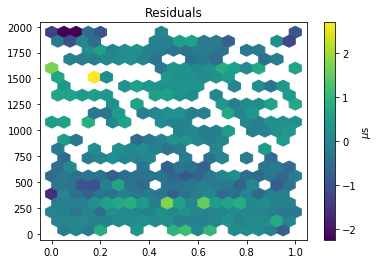

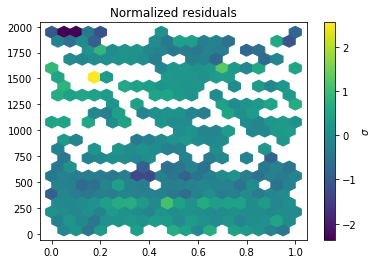

In [126]:
residuals = F.residuals()
plt.hexbin(
    ((F.mjds-F.base_mjd-F.best_parameters['tasc_i'])/F.best_parameters['pb_i'])%1, 
    F.mjds,
    C=residuals/F.reference_f0*1e6, gridsize=20)
plt.title("Residuals")
plt.colorbar().set_label(r"$\mu$s")
plt.figure()
plt.hexbin(
    ((F.mjds-F.base_mjd-F.best_parameters['tasc_i'])/F.best_parameters['pb_i'])%1, 
    F.mjds,
    C=residuals/F.phase_uncerts, gridsize=20)
plt.title("Normalized residuals")
plt.colorbar().set_label(r"$\sigma$")

print np.sum((residuals/F.phase_uncerts)**2), len(F.mjds)

In [127]:
M, linear_parameters = F.compute_linear_matrix()
linear_parameters

['FD1',
 'FD2',
 'FD3',
 'FD4',
 'd_DECJ',
 'd_DM',
 'd_PMDEC',
 'd_PMRA',
 'd_PX',
 'd_RAJ',
 'f0',
 'f1',
 'j_GBT_1400',
 'j_WSRT_1400',
 'phase']

In [128]:
M.shape

(27138, 15)

In [129]:
derivatives = {}

In [130]:
for i, p in enumerate(linear_parameters):
    derivatives[p] = M[:,i]

In [131]:
derivatives.update(nl_der)

## Annotating TOAs

In [132]:
extra = derivatives.copy()

toa_info = F.annotated_toas(extra, residuals=residuals)

## Exporting the information


In [133]:
np.savez_compressed(
    "systematics-package-%s.npz" % name,
    fitter_params=fitter_params,
    best_parameters=F.best_parameters,
    residuals=residuals,
    telescopes=F.tels,
    telescope_list=F.tel_list,
    orbit=orbit,
    times=F.mjds,
    base_mjd=F.base_mjd,
    phase_uncerts=F.phase_uncerts,
    linear_parameters=linear_parameters,
    derivatives=derivatives,
    toa_info=toa_info,
    )

In [134]:
d = dict(
    fitter_params=fitter_params,
    best_parameters=F.best_parameters,
    residuals=residuals,
    telescopes=F.tels,
    telescope_list=F.tel_list,
    f0=F.reference_f0,
    efacs=fitter_params['efac'],
    orbit=orbit,
    times=F.mjds,
    base_mjd=F.base_mjd,
    phase_uncerts=F.phase_uncerts,
    linear_parameters=linear_parameters,
    derivatives=derivatives,
    toa_info=toa_info,
    )
with open("systematics-package-%s.pickle" % name,"wb") as f:
    pickle.dump(d,f)

## Checking the quality of the derivatives and the fit

In [135]:
print F.parameters

['asini_i', 'pb_i', 'eps1_i', 'eps2_i', 'tasc_i', 'acosi_i', 'q_i', 'asini_o', 'pb_o', 'eps1_o', 'eps2_o', 'tasc_o', 'acosi_o', 'delta_lan', 'delta', 'dgamma', 'dbeta']


In [136]:
params = F.parameters + linear_parameters
#exclude = ["delta","dbeta","dgamma"]
exclude = []
trim_params = [p for p in params if p not in exclude]
Abig = np.array([derivatives[p] 
                 for p in trim_params], 
                dtype=np.longdouble).T
#print(Abig.shape)
r = threebody.lstsq_with_errors(Abig, residuals, F.phase_uncerts)
for i,p in enumerate(trim_params):
    print p, threebody.fmt(r.x[i], r.uncerts[i])
print r.singular_values

asini_i 5(2)e-7
pb_i 1.3(6)e-6
eps1_i -3.7(18)e-7
eps2_i 2.8(17)e-8
tasc_i 1.3(6)e-7
acosi_i 0(18)e-5
q_i 2(4)e-6
asini_o 1.6(11)e-5
pb_o 1.4(10)e-4
eps1_o 6(4)e-8
eps2_o 2.0(15)e-7
tasc_o 1.4(10)e-4
acosi_o 0(11)e-3
delta_lan 4(7)e-7
delta 2.0(17)e-7
dgamma -6(3)e-2
dbeta -1.5(5)e-1
FD1 0(10)e-1
FD2 0(9)e-1
FD3 0(5)e-1
FD4 0(15)e-2
d_DECJ 0(17)e-7
d_DM 0(12)e1
d_PMDEC 0(9)e-10
d_PMRA 0(3)e-10
d_PX 0(6)e0
d_RAJ 0(4)e-7
f0 0(4)e-9
f1 0(12)e-22
j_GBT_1400 0(5)e-6
j_WSRT_1400 1(10)e-6
phase 0(5)e-1
[  3.37999483e+00   2.29365937e+00   1.94736560e+00   1.55678765e+00
   1.36640023e+00   1.24453255e+00   1.05216661e+00   9.58916595e-01
   9.36832467e-01   8.19349849e-01   7.81164573e-01   7.55888131e-01
   6.64132379e-01   4.80580266e-01   3.55224692e-01   1.98173742e-01
   1.67403779e-01   1.64947078e-01   1.21660011e-01   1.03592154e-01
   8.24595178e-02   2.10567584e-02   1.79354337e-02   7.83223886e-03
   1.55635385e-03   1.10359009e-03   2.26577213e-04   3.30434478e-05
   1.10526936e-0

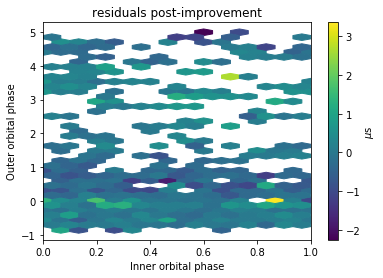

In [137]:
threebody.hexplot(F.best_parameters, F.mjds, 
                  r.residuals/F.reference_f0*1e6, 
                  gridsize=(15,20))
plt.colorbar(label=r"$\mu$s")
plt.title("residuals post-improvement")

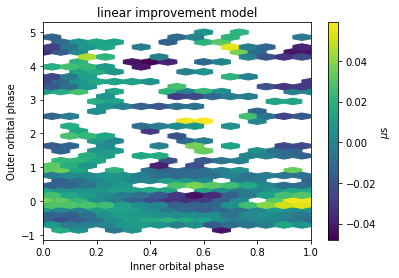

In [138]:
v = (residuals-r.residuals)
threebody.hexplot(F.best_parameters, F.mjds, 
                  v/F.reference_f0*1e6, 
                  gridsize=(15,20))
plt.colorbar(label=r"$\mu$s")
plt.title("linear improvement model")

In [139]:
bp = F.best_parameters.copy()
for p in F.parameters:
    i = params.index(p)
    bp[p] -= r.x[i]
pre = F.goodness_of_fit(F.best_parameters)
print "pre-improvement:", pre
post = F.goodness_of_fit(bp)
print "post-improvement:", post
if post<pre:
    with open("derivative-best-parameters.pickle","wb") as f:
        pickle.dump(bp, f)

pre-improvement: 39907.0546317
post-improvement: 7634274.73486


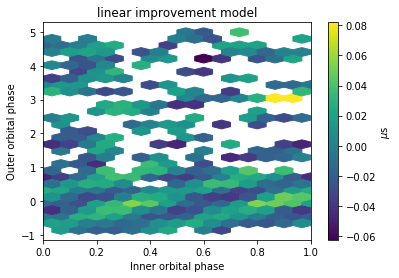

In [140]:
A = np.array([derivatives[p] 
              for p in derivatives.keys() if p!="delta"]).T
b = 1e-6*derivatives["delta"]
r = threebody.lstsq_with_errors(A, b, F.phase_uncerts)
v = r.residuals
threebody.hexplot(F.best_parameters, F.mjds, 
                  v/F.reference_f0*1e6, 
                  gridsize=(15,15))
plt.colorbar(label=r"$\mu$s")
plt.title("linear improvement model")